In [2]:
import numpy as np
from oceanmixedlayers import oceanmixedlayers
import matplotlib.pyplot as plt

import gsw as gsw
import xarray as xr
from glob import glob
import os
import warnings
from oct2py import octave
%matplotlib inline


def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0

In [3]:
#Some deep ones
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900331/'
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900451/'
PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900660/'
#Holte and Talley sample
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900621/'


PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    Z = gsw.conversions.z_from_p(Pressure, 
                                                 np.array(hndl.LATITUDE[p],dtype=float), 
                                                 geo_strf_dyn_height=0, 
                                                 sea_surface_geopotential=0)
                    P_i = np.array([0.]+list(Pressure))
                    Z_i = np.array([0.]+list(Z))
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:
                        gsdh = gsw.geostrophy.geo_strf_dyn_height(PSal, 
                                                                  CT, 
                                                                  Pressure, 
                                                                  p_ref=0, 
                                                                  axis=0, 
                                                                  max_dp=1.0, 
                                                                  interp_method='pchip')
                        Z = gsw.conversions.z_from_p(Pressure, 
                                                     np.array(hndl.LATITUDE[p],dtype=float), 
                                                     geo_strf_dyn_height=gsdh, 
                                                     sea_surface_geopotential=0)
                        Z_i = np.array([0.]+list(Z))
                        dZ = (Z_i[:-1]-Z_i[1:])
                        Z = gsw.conversions.z_from_p(Pressure, 
                                                     np.array(hndl.LATITUDE[p],dtype=float), 
                                                     geo_strf_dyn_height=gsdh, 
                                                     sea_surface_geopotential=0)
                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c = 0.5*(P_i[1:]+P_i[:-1])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        CT_c = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                                 

OK


/net/bgr/Python/Packages/oceanmixedlayers/src/oceanmixedlayers/energy2mix.py:15: RuntimeWarning: invalid value encountered in true_divide
  T_Mixed = np.sum((Tracer*dZ)[:nlev,...],axis=0)/DZ_Mixed
<ipython-input-4-a501c9c0b85f>:94: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,)


(0.0, 6.25)

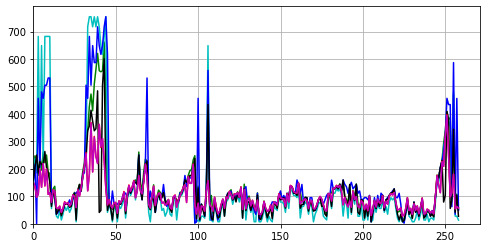

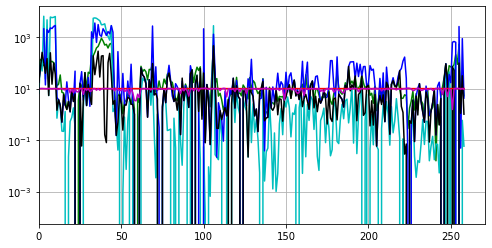

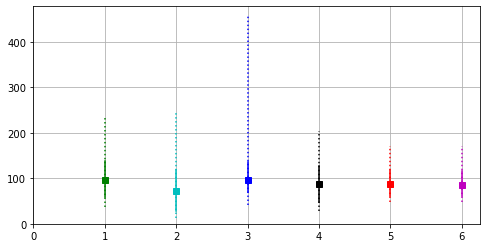

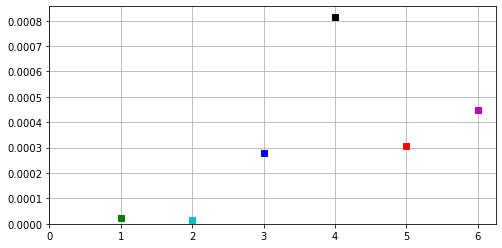

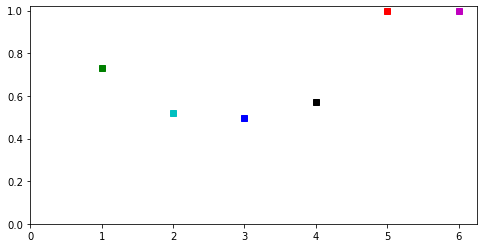

In [4]:
import time

_=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(P_c_2d[GOOD,:].T,Rho0_c_2d[GOOD,:].T,delta=0.03,ref=10)  
a=time.time()
MLD_gradient,MLD_gradienti = oceanmixedlayers.gradient(P_c_2d[GOOD,:].T,-Rho0_c_2d[GOOD,:].T,critical_gradient=0.0005)  
b=time.time()
MLD_linfit,MLD_linfiti = oceanmixedlayers.linearfit(P_c_2d[GOOD,:].T,-Rho0_c_2d[GOOD,:].T,error_tolerance=1.e-10)  
c=time.time()
OUT = oceanmixedlayers.holtetalley(P_c_2d[GOOD,:].T,
                                 PSal_c_2d[GOOD,:].T,
                                 CT_c_2d[GOOD,:].T,
                                 Rho0_c_2d[GOOD,:].T)
MLD_ht=OUT[2]
d=time.time()
MLD_pelin = oceanmixedlayers.pe_anomaly_density(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          energy=10.,
                                          gradient=True
                                         )
e=time.time()
MLD_pe = oceanmixedlayers.pe_anomaly_density(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          energy=10.
                                         )
f=time.time()

e_MLD_003 = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_003,
                                          gradient=True
                                         )
e_MLD_gradient = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_gradient,
                                          gradient=True
                                         )
e_MLD_linfit = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_linfit,
                                          gradient=True
                                         )
e_MLD_ht = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_ht,
                                          gradient=True
                                         )
e_MLD_pelin = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pelin,
                                          gradient=True
                                         )
e_MLD_pe = oceanmixedlayers.energy2mix(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pe,
                                          gradient=True
                                         )
f=time.time()

plt.figure(figsize=(8,4))
plt.plot(MLD_003,'g-')
plt.plot(MLD_gradient,'c-')
plt.plot(MLD_linfit,'b-')
plt.plot(MLD_ht,'k-')
plt.plot(MLD_pelin,'r-')
plt.plot(MLD_pe,'m-')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
plt.semilogy(e_MLD_003,'g-')
plt.plot(e_MLD_gradient,'c-')
plt.plot(e_MLD_linfit,'b-')
plt.plot(e_MLD_ht,'k-')
plt.plot(e_MLD_pelin,'r-')
plt.plot(e_MLD_pe,'m-')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
def boxwhisk(index,MLD,color='k'):
    plt.plot(index,np.median(MLD),'s',color=color)
    plt.plot([index,index],[np.percentile(MLD,10),np.percentile(MLD,90)],':',color=color)
    plt.plot([index,index],[np.percentile(MLD,25),np.percentile(MLD,75)],'-',color=color)
boxwhisk(1,MLD_003,color='g')
boxwhisk(2,MLD_gradient,color='c')
boxwhisk(3,MLD_linfit,color='b')
boxwhisk(4,MLD_ht,color='k')
boxwhisk(5,MLD_pelin,color='r')
boxwhisk(6,MLD_pe,color='m')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
boxwhisk(1,(a-_)/np.sum(GOOD),color='g')
boxwhisk(2,(b-a)/np.sum(GOOD),color='c')
boxwhisk(3,(c-b)/np.sum(GOOD),color='b')
boxwhisk(4,(d-c)/np.sum(GOOD),color='k')
boxwhisk(5,(e-d)/np.sum(GOOD),color='r')
boxwhisk(6,(f-e)/np.sum(GOOD),color='m')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
plt.plot(1,np.corrcoef(MLD_pelin,MLD_003)[1,0]**2,'gs')
plt.plot(2,np.corrcoef(MLD_pelin,MLD_gradient)[1,0]**2,'cs')
plt.plot(3,np.corrcoef(MLD_pelin,MLD_linfit)[1,0]**2,'bs')
plt.plot(4,np.corrcoef(MLD_pelin,MLD_ht)[1,0]**2,'ks')
plt.plot(5,np.corrcoef(MLD_pelin,MLD_pelin)[1,0]**2,'rs')
plt.plot(6,np.corrcoef(MLD_pelin,MLD_pe)[1,0]**2,'ms')
plt.ylim(0.,1.02)
plt.xlim(0,)
